In [14]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [26]:
def compute_l_p_m(N, lower_bound, upper_bound):
    """
    Compute:
      l(n,k) = number of (N-n)-step paths starting at X_n=k that stay within bounds
      p(n,k) = l(n+1,k+1) / l(n,k)
      m(n,k) = max(k, p(n,k) * m(n+1,k+1) + (1-p(n,k)) * m(n+1,k-1))
    Returns dictionaries: l, p, m, valid_ks
    """
    l = defaultdict(int)
    p = dict()
    m = dict()
    valid_ks = dict()

    for n in range(0, N+1):
        lo = int(lower_bound(n))
        hi = int(upper_bound(n))
        valid_ks[n] = list(range(lo, hi+1))

    for k in valid_ks[N]:
        l[(N,k)] = 1

    for n in range(N-1, -1, -1):
        for k in valid_ks[n]:
            val = 0
            if (k+1) in valid_ks[n+1]:
                val += l[(n+1, k+1)]
            if (k-1) in valid_ks[n+1]:
                val += l[(n+1, k-1)]
            l[(n,k)] = val

    for n in range(0, N):
        for k in valid_ks[n]:
            denom = l[(n,k)]
            if denom > 0:
                numer = l.get((n+1, k+1), 0)
                p[(n,k)] = numer / denom
            else:
                p[(n,k)] = 0.0

    for k in valid_ks[N]:
        m[(N,k)] = k

    for n in range(N-1, -1, -1):
        for k in valid_ks[n]:
            prob = p.get((n,k), 0.0)
            m_up = m.get((n+1, k+1), k+1)
            m_down = m.get((n+1, k-1), k-1)
            candidate = prob * m_up + (1 - prob) * m_down
            m[(n,k)] = max(k, candidate)

    return m, valid_ks


In [27]:
N = 6
lower_bound = lambda x : - 2 - 0 * x
upper_bound = lambda x : 2 + 0 * x

In [28]:
m, valid = compute_l_p_m(6, lower_bound, upper_bound)

In [29]:
real_valid = valid.copy()
for k in valid[0]:
    real_valid[0][k] = 0
real_valid[0][0] = 1

for n in range(1, N+1):
    for k in valid[n]:
        real_valid[n][k] = 0
        if k - 1 in valid[n - 1]:
            real_valid[n][k] = max(real_valid[n][k], real_valid[n - 1][k - 1])
        if k + 1 in valid[n - 1]:
            real_valid[n][k] = max(real_valid[n][k], real_valid[n - 1][k + 1])


In [ ]:
real_valid = valid.copy()
for k in valid[0]:
    real_valid[0][k] = 0
real_valid[0][0] = 1

for n in range(1, N+1):
    for k in valid[n]:
        real_valid[n][k] = 0
        if k - 1 in valid[n - 1]:
            real_valid[n][k] = max(real_valid[n][k], real_valid[n - 1][k - 1])
        if k + 1 in valid[n - 1]:
            real_valid[n][k] = max(real_valid[n][k], real_valid[n - 1][k + 1])
            
def reachable_from_zero(n, k):
    return real_valid[n][k]

In [49]:
# ------------------------------------------------------
# PARAMETERS
# ------------------------------------------------------
N = 6
lower_bound  = lambda n: -2
upper_bound  = lambda n:  2 + n

# ------------------------------------------------------
# COMPUTE l(n,k), p(n,k), m(n,k)
# ------------------------------------------------------
def compute_l_p_m(N, lower_bound, upper_bound):
    l = defaultdict(int)
    p = {}
    m = {}
    valid = {}

    # Valid k values at each n based on bounds
    for n in range(N+1):
        lo = int(lower_bound(n))
        hi = int(upper_bound(n))
        valid[n] = list(range(lo, hi+1))

    # Terminal condition for l
    for k in valid[N]:
        l[(N,k)] = 1

    # Compute l backwards
    for n in range(N-1, -1, -1):
        for k in valid[n]:
            l[(n,k)] = l.get((n+1, k+1), 0) + l.get((n+1, k-1), 0)

    # Compute p
    for n in range(N):
        for k in valid[n]:
            denom = l[(n,k)]
            if denom == 0:
                p[(n,k)] = 0
            else:
                p[(n,k)] = l.get((n+1, k+1), 0) / denom

    # Terminal condition for m
    for k in valid[N]:
        m[(N,k)] = k

    # Compute m backwards
    for n in range(N-1, -1, -1):
        for k in valid[n]:
            pu = p[(n,k)]
            m_next = pu * m.get((n+1, k+1), k+1) + (1 - pu) * m.get((n+1, k-1), k-1)
            m[(n,k)] = max(k, m_next)

    return l, p, m, valid


l, p, m, valid = compute_l_p_m(N, lower_bound, upper_bound)

# ------------------------------------------------------
# DETERMINE REACHABLE STATES
# ------------------------------------------------------
real_valid = {n: {} for n in range(N+1)}

# Only k = 0 reachable at n = 0
for k in valid[0]:
    real_valid[0][k] = 0
real_valid[0][0] = 1

# Forward dynamic reachability
for n in range(1, N+1):
    for k in valid[n]:
        real_valid[n][k] = 0
        if (k-1) in valid[n-1] and real_valid[n-1].get(k-1, 0):
            real_valid[n][k] = 1
        if (k+1) in valid[n-1] and real_valid[n-1].get(k+1, 0):
            real_valid[n][k] = 1

def reachable_from_zero(n, k):
    return real_valid[n].get(k, 0) == 1


## ------------------------------------------------------
## PLOT
## ------------------------------------------------------
#plt.figure(figsize=(11,6))
#ax = plt.gca()
#
## Draw all edges (same color)
#for n in range(N):
#    for k in valid[n]:
#        if not reachable_from_zero(n, k):
#            continue
#        # connect to k+1
#        if reachable_from_zero(n+1, k+1):
#            ax.plot([n, n+1], [k, k+1], color="black")
#        # connect to k-1
#        if reachable_from_zero(n+1, k-1):
#            ax.plot([n, n+1], [k, k-1], color="black")
#
## Draw nodes + labels
#for n in range(N+1):
#    for k in valid[n]:
#        if not reachable_from_zero(n, k):
#            continue
#        value = m[(n,k)]
#        is_hit = abs(value - k) < 1e-12  # m(n,k) = k
#
#        # Diamond for m(n,k) = k, circle otherwise
#        ax.scatter(n, k, marker=("." if is_hit else "o"), color="black")
#
#        # Slight text shift upward
#        ax.text(n, k + 0.15, f"{value:.2f}",
#                ha='center', va='bottom', fontsize=9)
#
#ax.set_xlabel("n (time step)")
#ax.set_ylabel("k (state)")
#ax.set_title("Reachable States with m(n,k) Values\n(diamond marks where m(n,k) = k)")
#ax.grid(True)
#
#plt.tight_layout()
#plt.show()


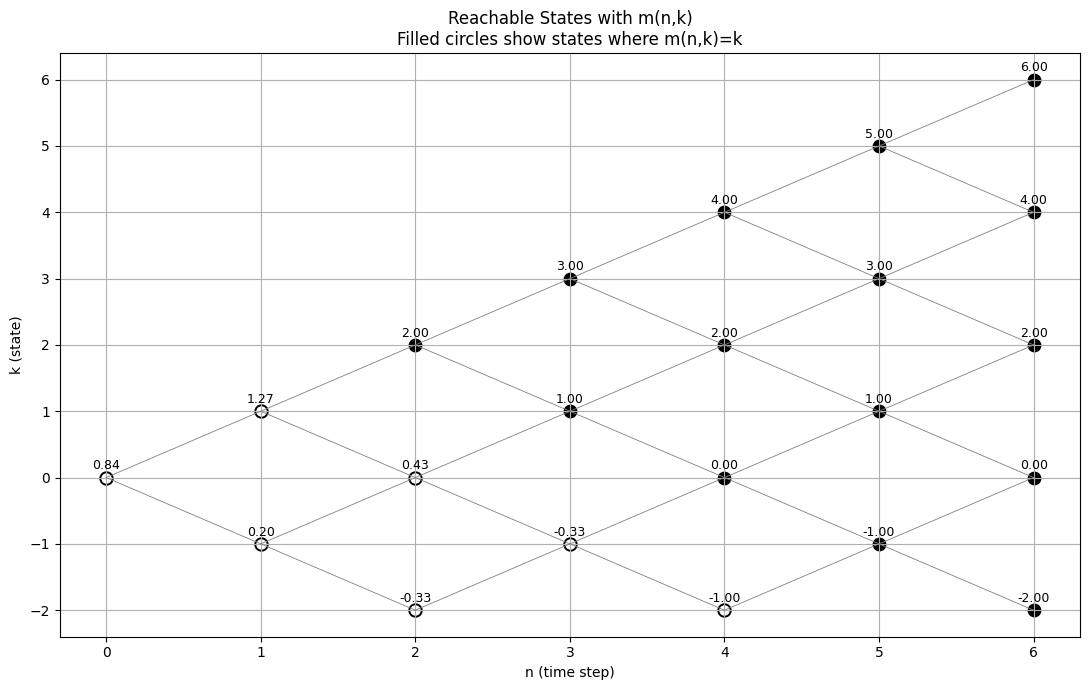

In [118]:
# ------------------------------------------------------
# PLOT WITH IMPROVED READABILITY
# ------------------------------------------------------
plt.figure(figsize=(11,7))
ax = plt.gca()

# Thinner, light gray edges
for n in range(N):
    for k in valid[n]:
        if not reachable_from_zero(n, k):
            continue
        if reachable_from_zero(n+1, k+1):
            ax.plot([n, n+1], [k, k+1], color="gray", linewidth=0.6)
        if reachable_from_zero(n+1, k-1):
            ax.plot([n, n+1], [k, k-1], color="gray", linewidth=0.6)

# Distinct node styles
for n in range(N+1):
    for k in valid[n]:
        if not reachable_from_zero(n, k):
            continue

        value = m[(n,k)]
        is_hit = abs(value - k) < 1e-12

        if is_hit:
            # Filled black circle
            ax.scatter(n, k, s=80, color="black")
        else:
            # Hollow circle
            ax.scatter(n, k, s=80, facecolors="white", edgecolors="black", linewidth=1.4)

        # Shifted label
        ax.text(n, k + 0.08, f"{value:.2f}",
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel("n (time step)")
ax.set_ylabel("k (state)")
ax.set_title("Reachable States with m(n,k)\nFilled circles show states where m(n,k)=k")
ax.grid(True)

plt.tight_layout()
plt.savefig("images/mnk_example.png", dpi=300)

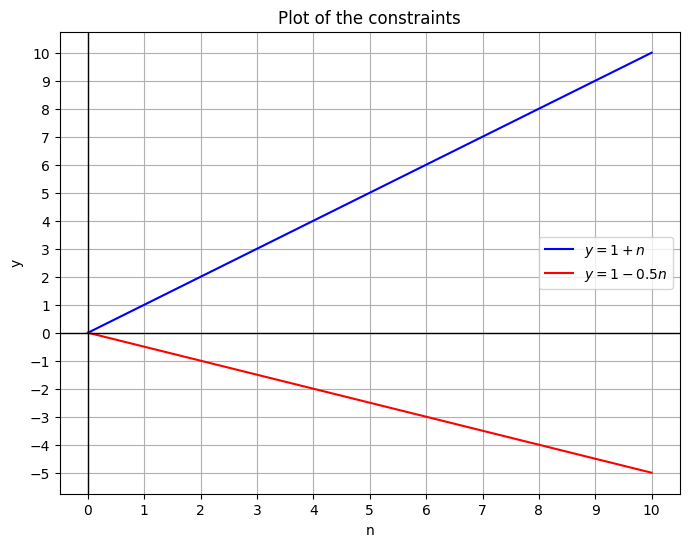

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range for n (non-negative values)
n = np.arange(0, 11, 1)  # Integer values from 0 to 10

# Define the two equations
y1 = 1 + n
y2 = -1 - 0.5 * n

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the two lines
plt.plot(n, y1, label=r'$y = 1 + n$', color='b')
plt.plot(n, y2, label=r'$y = 1 - 0.5n$', color='r')

# Add labels and title
plt.xlabel('n')
plt.ylabel('y')
plt.title('Plot of the constraints')

# Add a legend
plt.legend()

# Display the grid
plt.grid(True)

# Add x and y axes at 0
plt.axhline(0, color='black', linewidth=1)  # y = 0 axis
plt.axvline(0, color='black', linewidth=1)  # x = 0 axis

# Adjust the ticks on the y-axis (step size = 1)
plt.yticks(np.arange(min(y1.min(), y2.min()), max(y1.max(), y2.max()) + 1, 1))

# Adjust the ticks on the x-axis (step size = 1)
plt.xticks(n)  # Use the same values as n for x-axis ticks

# Set the aspect ratio to 'equal' to ensure square grid cells
#plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()


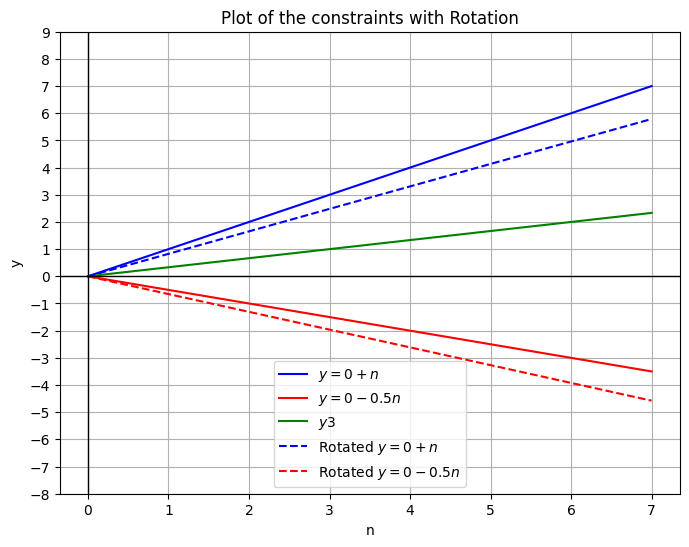

The angle between the two lines is 18.43 degrees.
The plot was rotated by -9.22 degrees.


In [82]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Define the range for n (non-negative values)
n = np.arange(0, 8, 1)  # Integer values from 0 to 10

# Define the two equations
y1 = n
y2 = -0.5 * n

# Calculate the slopes
m1 = 1  # Slope of the first line (y = 1 + n)
m2 = +0.5  # Slope of the second line (y = 1 - 0.5n)

# Calculate the angle between the two lines using the formula
tan_alpha = abs((m1 - m2) / (1 + m1 * m2))
y3 = tan_alpha * n
alpha = math.atan(tan_alpha)  # Angle in radians

# Angle of rotation is alpha / 2
rotation_angle = -alpha / 2  # Negative for counterclockwise rotation

# Define rotation function
def rotate(x, y, angle):
    """Rotate the point (x, y) by the given angle (in radians)"""
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the two lines
plt.plot(n, y1, label=r'$y = 0 + n$', color='b')
plt.plot(n, y2, label=r'$y = 0 - 0.5n$', color='r')
plt.plot(n, y3, label=r'$y3$', color='g')

# Rotate the points for the plot
n_rot = n  # n values stay the same
y1_rot, y2_rot = [], []
for i in range(len(n)):
    x1_rot, y1_rot_val = rotate(n[i], y1[i], rotation_angle)
    x2_rot, y2_rot_val = rotate(n[i], y2[i], rotation_angle)
    y1_rot.append(y1_rot_val)
    y2_rot.append(y2_rot_val)

# Plot the rotated lines
plt.plot(n_rot, y1_rot, label=r'Rotated $y = 0 + n$', linestyle='--', color='b')
plt.plot(n_rot, y2_rot, label=r'Rotated $y = 0 - 0.5n$', linestyle='--', color='r')

# Add labels and title
plt.xlabel('n')
plt.ylabel('y')
plt.title('Plot of the constraints with Rotation')

# Add a legend
plt.legend()

# Display the grid
plt.grid(True)

# Add x and y axes at 0
plt.axhline(0, color='black', linewidth=1)  # y = 0 axis
plt.axvline(0, color='black', linewidth=1)  # x = 0 axis

# Adjust the ticks on the y-axis (step size = 1)
plt.yticks(np.arange(-8, 10, 1))

# Adjust the ticks on the x-axis (step size = 1)
plt.xticks(n)  # Use the same values as n for x-axis ticks

# Show the plot
plt.show()

# Print the calculated angle alpha in degrees
print(f"The angle between the two lines is {alpha * 180 / np.pi:.2f} degrees.")
print(f"The plot was rotated by {rotation_angle * 180 / np.pi:.2f} degrees.")


The angle between the two lines is 18.43 degrees.
The plot was rotated by -9.22 degrees.


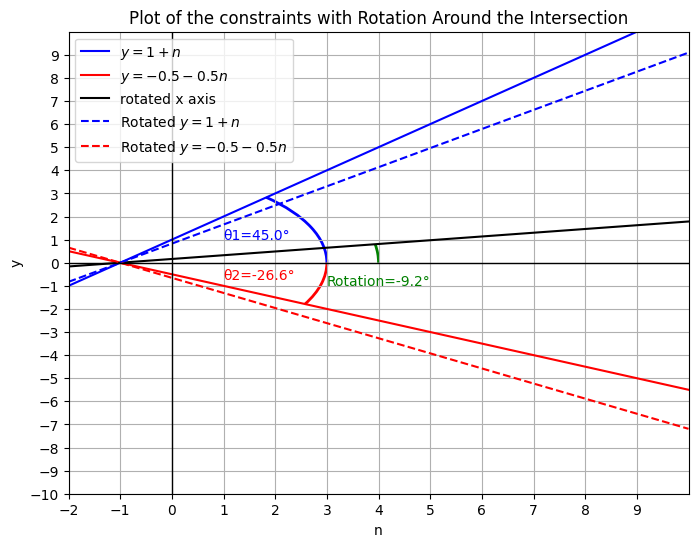

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.patches import Arc

# Define the range for n (non-negative values)
n = np.arange(-2, 11, 1)  # Integer values from 0 to 10

# Define the two equations
y1 = 1 + n  # First line: y = 1 + n
y2 = -0.5 - 0.5 * n  # Second line: y = -0.5 - 0.5n (updated equation)

# Calculate the slopes
m1 = 1  # Slope of the first line (y = 1 + n)
m2 = +0.5  # Slope of the second line (y = -0.5 - 0.5n)

theta1 = math.atan(m1)
theta2 = math.atan(-m2)

# Calculate the angle between the two lines using the formula
tan_alpha = abs((m1 - m2) / (1 + m1 * m2))
alpha = math.atan(tan_alpha)  # Angle in radians

# Angle of rotation is alpha / 2 (in negative direction)
rotation_angle = -alpha / 2  # Negative for counterclockwise rotation
y3 = math.tan(-rotation_angle) + math.tan(-rotation_angle) * n

# Define rotation function
def rotate(x, y, angle):
    """Rotate the point (x, y) by the given angle (in radians)"""
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

# Translate points so the intersection (-1, 0) becomes the origin
def translate_to_origin(x, y, translate_x, translate_y):
    """Translate points by (translate_x, translate_y)"""
    return x - translate_x, y - translate_y

def translate_back(x, y, translate_x, translate_y):
    """Translate points back by (translate_x, translate_y)"""
    # Convert x and y to numpy arrays for element-wise addition
    x, y = np.array(x), np.array(y)
    return x + translate_x, y + translate_y

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the two lines
plt.plot(n, y1, label=r'$y = 1 + n$', color='b')
plt.plot(n, y2, label=r'$y = -0.5 - 0.5n$', color='r')
plt.plot(n, y3, label=r'rotated x axis', color='k')

# Coordinates of the intersection point (-1, 0)
intersection_x = -1
intersection_y = 0

# Translate the lines so that the intersection point becomes the origin
n_translated, y1_translated = translate_to_origin(n, y1, intersection_x, intersection_y)
_, y2_translated = translate_to_origin(n, y2, intersection_x, intersection_y)

# Rotate the translated points around the origin
y1_rotated, y2_rotated = [], []
for i in range(len(n)):
    x1_rot, y1_rot_val = rotate(n_translated[i], y1_translated[i], rotation_angle)
    x2_rot, y2_rot_val = rotate(n_translated[i], y2_translated[i], rotation_angle)
    y1_rotated.append(y1_rot_val)
    y2_rotated.append(y2_rot_val)

# Convert the rotated points back to their original positions
n_rotated, y1_rotated_back = translate_back(n_translated, y1_rotated, intersection_x, intersection_y)
_, y2_rotated_back = translate_back(n_translated, y2_rotated, intersection_x, intersection_y)

# Plot the rotated lines
plt.plot(n_rotated, y1_rotated_back, label=r'Rotated $y = 1 + n$', linestyle='--', color='b')
plt.plot(n_rotated, y2_rotated_back, label=r'Rotated $y = -0.5 - 0.5n$', linestyle='--', color='r')

# Add labels and title
plt.xlabel('n')
plt.ylabel('y')
plt.title('Plot of the constraints with Rotation Around the Intersection')

# Add a legend
plt.legend()

# Display the grid
plt.grid(True)

# Add x and y axes at 0
plt.axhline(0, color='black', linewidth=1)  # y = 0 axis
plt.axvline(0, color='black', linewidth=1)  # x = 0 axis

# Draw angle arcs
arc_radius = 4.0  # radius of the arcs

# θ1 arc (blue)
theta1_deg = np.degrees(theta1)
arc1 = Arc((intersection_x, intersection_y), 2*arc_radius, 2*arc_radius, angle=0,
           theta1=0, theta2=theta1_deg, color='blue', linewidth=2)
plt.gca().add_patch(arc1)
plt.text(intersection_x + 2, intersection_y + 1, f'θ1={theta1_deg:.1f}°', color='blue')

# θ2 arc (red)
theta2_deg = np.degrees(theta2)
arc2 = Arc((intersection_x, intersection_y), 2*arc_radius, 2*arc_radius, angle=0,
           theta1=theta2_deg, theta2=0, color='red', linewidth=2)
plt.gca().add_patch(arc2)
plt.text(intersection_x + 2, intersection_y - 0.7, f'θ2={theta2_deg:.1f}°', color='red')

# Rotation angle arc (purple) near rotated lines
arc_radius = 5.0
rot_deg = np.degrees(rotation_angle)
arc3 = Arc((intersection_x, intersection_y), 2*arc_radius, 2*arc_radius, angle=0,
           theta1=0, theta2=-rot_deg, color='green', linewidth=2)
plt.gca().add_patch(arc3)
plt.text(intersection_x + 4, intersection_y -1, f'Rotation={rot_deg:.1f}°', color='green')

# Adjust the ticks on the y-axis (step size = 1)
plt.yticks(np.arange(-10, 10))

# Adjust the ticks on the x-axis (step size = 1)
plt.xticks(np.arange(-2, 10))  # Use the same values as n for x-axis ticks

# Adjusting the axis limits based on the rotated lines
plt.xlim(- 2, 10)  # Add padding for x-axis
plt.ylim(-10, 10)  # Add padding for y-axis

# Show the plot
#plt.show()
plt.savefig('images/rotation_example.png', dpi=300)

# Print the calculated angle alpha in degrees
print(f"The angle between the two lines is {alpha * 180 / np.pi:.2f} degrees.")
print(f"The plot was rotated by {rotation_angle * 180 / np.pi:.2f} degrees.")
